In [1]:
from IPython.core.display import display
from __future__ import division
import numpy as np
import pandas as pd
from datautils.data_utils import get_more_data, merge_trades_and_quotes
import datautils.features as features
from backtest.backtest import backtest, Order

import statsmodels.api as sm
from sklearn import svm, preprocessing

%matplotlib inline

In [2]:
import time
start = time.time()
datas = get_more_data('XLE', 2012, 2, 1, days=29, bar_width='second', start_hour=10)

In [3]:
def cross_validation(data, clf, feature_columns, ycol='label', label='label', K=5,
                     fit_method=lambda cl, X, y: cl.fit(X, y),
                     predict_method=lambda cl, X: cl.predict(X)):
    """

    :param data:
    :param clf:
    :param feature_columns:
    :param label:
    :param K:
    :param fit_method:
    :param predict_method:
    :return:

    define false positive as predicting incorrect 1 or -1 value
    examples:
    true    predicted
    0,-1       1
    0,1       -1

    counter-examples:
    0,1,-1      0
    1           1
    -1          -1
    """
    #data.apply(np.random.shuffle, axis=0)
    partitions = np.array_split(data, K)

    weights = []

    results = {
        'run': range(1, K+1) + ['Total'],
        'acc': [None]*(K+1),
        'acc*': [None]*(K+1),
        'fpr': [None]*(K+1),
        'fnr': [None]*(K+1),
        'bpr': [None]*(K+1),
        'gpr': [None]*(K+1)
    }

    for k in xrange(K):
        training_data = pd.concat(partitions[:k] + partitions[(k+1):])
        testing_data = partitions[k]
        train_x, train_y = training_data[feature_columns], training_data[ycol]
        test_x, test_y = testing_data[feature_columns], testing_data[label]
        fit_method(clf, train_x, train_y)
        pred_y = predict_method(clf, test_x)
        n = np.size(test_y)
        results['acc'][k] = np.sum(pred_y == test_y) / n
        results['acc*'][k] = np.mean([np.sum((pred_y == test_y) & (test_y == L)) / np.sum(test_y == L) for L in [-1, 0, 1]])
        results['fpr'][k] = np.sum((pred_y != test_y) & (pred_y != 0)) / np.sum(pred_y != 0)
        results['fnr'][k] = np.sum((pred_y != test_y) & (pred_y == 0)) / np.sum(pred_y == 0)
        results['bpr'][k] = np.sum((pred_y * test_y) == -1) / np.sum(test_y != 0)
        results['gpr'][k] = np.sum((pred_y == test_y) & (test_y != 0)) / np.sum(test_y != 0)
        #results['-1'][k] = np.sum(pred_y == -1)
        #results['0'][k] = np.sum(pred_y == 0)
        #results['1'][k] = np.sum(pred_y == 1)

        if hasattr(clf, 'coef_'):
            W = clf.coef_
            weights.append(pd.DataFrame({'-1': W[0], '0': W[1], '1': W[2]}, index=feature_columns))

    for col in results:
        if col != 'run':
            results[col][K] = np.mean(results[col][:K])

    if hasattr(clf, 'coef_'):
        mean_weights = sum(weights) / K
    else:
        mean_weights = []

    return pd.DataFrame(results).set_index('run'), mean_weights


def clf_output(cv_results, y, K):
    print """
                                 Results
==============================================================================
    """
    print pd.DataFrame({'%': np.array([len(y[y == -1]),
                                len(y[y == 0]),
                                len(y[y == 1])])/len(y)},
                       index=[-1, 0, 1])
    print pd.DataFrame({'values': [(len(y)/K)*(K-1)]}, index=['Training Size / Fold'])
    print cv_results[0]
    print cv_results[1]
    print "=============================================================================="


## Add Features

In [4]:
hls = [10, 40, 100]
crossover_hls = (10, 40)
for data, trades in datas:
    features.add_future_log_returns(data, label_hls=hls)
    features.add_future_log_returns_rolling(data, windows=(10, 30, 60))
    features.add_crossover(data, halflives=crossover_hls)

In [5]:
# hls = [10, 40, 100]
# crossover_hls = (10, 40)
# vpin_window = pd.Timedelta(seconds=30)
feature_names = []
for data, trades in datas:
#     features.add_future_log_returns(data, label_hls=hls)
#     features.add_future_log_returns_rolling(data, windows=(10, 30, 60))
    feature_names += features.add_price_dema(data, halflives=hls)
    feature_names += features.add_momentum(data, halflives=hls)
    feature_names += features.add_log_return_ema(data, halflives=hls)
    feature_names += features.add_price_diff(data)
    feature_names += features.add_size_diff(data)
    #feature_names += features.add_vpin_time(data, window=dt.timedelta(seconds=20))
    #feature_names += features.add_dema_sum(data, halflives=hls)
    feature_names += features.add_dema_sum(data, halflives=hls)
    feature_names += features.add_dema(data, features=['momentum', 'dEMA_10', 'dEMA_40', 'dEMA_100', 'dEMA_sum'])
#     features.add_crossover(data, halflives=crossover_hls)
    
feature_names = list(set(feature_names))
data = pd.concat(zip(*datas)[0])
data[feature_names] = (data[feature_names] - data[feature_names].mean()) / data[feature_names].std()
data = data.fillna(0)

pred_col = 'log_returns_10+'

## Linear SVM, 3-class 5-fold CV, no-class weights 

In [6]:
filtered_data = data[data['crossover?'] == True]
# display(filtered_data)
# filtered_data = data

#run 1
thresh = 0.000005/2
hl = 100
K = 5

filtered_data['label'] = 0
filtered_data.ix[filtered_data[pred_col] > thresh, 'label'] = 1
filtered_data.ix[filtered_data[pred_col] < -thresh, 'label'] = -1

clf = svm.LinearSVC(C=1.0, class_weight='auto')
cv_results = cross_validation(filtered_data, clf, feature_names, label='label', K=5)
y = filtered_data['label'].values

print """
Filtered-data Linear SVM, 3-class 5-fold CV, auto class weights
"""
print "crossover_hls = {}".format(crossover_hls)
print "Pred_col = {}".format(pred_col)
print "thresh = {}".format(thresh)
clf_output(cv_results, y, K)


Filtered-data Linear SVM, 3-class 5-fold CV, auto class weights

crossover_hls = (10, 40)
Pred_col = log_returns_10+
thresh = 2.5e-06

                                 Results
    
           %
-1  0.392371
 0  0.195407
 1  0.412223
                      values
Training Size / Fold  2055.2
            acc      acc*       bpr       fnr       fpr       gpr
run                                                              
1      0.531128  0.426842  0.352804  0.833333  0.464567  0.635514
2      0.517510  0.434901  0.348039  0.500000  0.482422  0.649510
3      0.498054  0.423294  0.375610  0.500000  0.501969  0.617073
4      0.533074  0.445242  0.334951  0.500000  0.466797  0.662621
5      0.534113  0.447583  0.325183  0.750000  0.463654  0.667482
Total  0.522776  0.435572  0.347318  0.616667  0.475882  0.646440
                            -1         0         1
size_diff            -0.143987 -0.007520  0.163097
dEMA_100              0.263140 -0.093629 -0.123275
log_returns_std_100- -0.017

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/indexing.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Backtest


In [7]:
import datetime

def backtest(strategy, quotes, trades=None, transaction_costs=0.005, slippage_rate=0.25, delay_fill=False, *args, **kwargs):
    """
    description: backtest a trading strategy
    inputs:
        @quotes - quotes as a Pandas DataFrame, columns - [DATE_TIME, SYM, BID_PRICE, BID_SIZE, ASK_PRICE, ASK_SIZE]
        @strategy - callable function taking two parameters
                        'datautils': dictionary of symbol(string) -> security_data(pd.Series)
                        'positions': dictionary of symbol(string) -> position(int)
                    function is called at each minimum time increment, and should return a list of Order objects
        @transaction_costs - transaction cost per contract per trade
    output:
        pnl history: list of numbers, your pnl at each time increment
        order history: list of order objects, at each time increment
    """

    cash = [0.0]
    pnl_history = [0]
    order_history = []
    positions = {}
    security_data = {}
    recent_trades = [[]]

    slippage = lambda price, qty, _book_qty: price + 0.01 * slippage_rate * (qty/_book_qty + 1)

    def check_signals(quotes):
        # run strategy
        if len(security_data) > 0 and delay_fill:
            orders = strategy(security_data, recent_trades[0], positions, *args, **kwargs)
        for i in xrange(0, len(quotes)):
            security_data[quotes.iloc[i]['SYM']] = quotes.iloc[i]
        time = quotes.iloc[0]['DATE_TIME']
        if trades is not None:
            recent_trades[0] = trades[(trades['DATE_TIME'] >= time) & (trades['DATE_TIME'] < time + datetime.timedelta(seconds=1))]
        if not delay_fill:
            orders = strategy(security_data, recent_trades[0], positions)
        # process orders
        for order in orders:
            if order.qty == 0:
                continue
            sdata = security_data[order.sym]
            positions[order.sym] = positions.get(order.sym, 0) + order.qty
            price = sdata['BID_PRICE'] if order.qty > 0 else sdata['ASK_PRICE']
            book_qty = sdata['BID_SIZE'] if order.qty > 0 else sdata['ASK_SIZE']
            price = slippage(price, order.qty, book_qty)
            order_history.append((time, order.sym, order.qty, price))
            cash[0] -= order.qty * price
            cash[0] -= transaction_costs * abs(order.qty)
        portfolio_value = np.sum(
            [positions[sym] * (security_data[sym]['BID_PRICE'] if positions[sym] > 0 else security_data[sym]['ASK_PRICE']) for sym in
             positions])
        pnl_history.append(cash[0] + portfolio_value)

    quotes.groupby('DATE_TIME').apply(check_signals)

    return pnl_history[1:], order_history


In [13]:
def strategy(data, trades, positions):
    orders = []
#     indicator = 'log_returns_100+'
#     entry_threshold = 0.000005
#     exit_threshold = 0.000001
    
# #     instance = data[feature_names].values
# #     prediction = clf.predict(np.nan_to_num(instance))
#     global count
#     count += 1
#     if count < 30:
#         return[]

#     base_qty = 10
#     max_pos = 100

#     print data.columns.values
#     print data['crossover?']
    
#     if data['crossover?'].iloc(0) == True:
#         print "TRUE"
#         pos = positions.get(sym, 0)
#         qty = base_qty*int(quotes[sym][indicator]/entry_threshold) - pos
#         if prediction == ['1']:
    orders.append(Order('XLE', 100, type='market'))
#         elif prediction == ['-1']:
#     orders.append(Order('XLE', -pos, type='market'))

    return orders

In [14]:
count = 0
# display(quotes)
# backtest_clf = svm.SVC(C=1.0, class_weight='auto')
# train_x = filtered_data[feature_names]
# train_y = filtered_data['label']
# backtest_clf.fit(train_x, train_y)
# print "fit classifier"
quotes_list, trades_list = zip(*datas)
quotes = pd.concat(quotes_list)
trades = pd.concat(trades_list)
# display(quotes[1:100])
# partial = quotes[1:100]
# print len(partial)
pnl_history, order_history = backtest(strategy, quotes, trades, transaction_costs=0.005, slippage_rate=0.25, delay_fill=True)

219858
219858


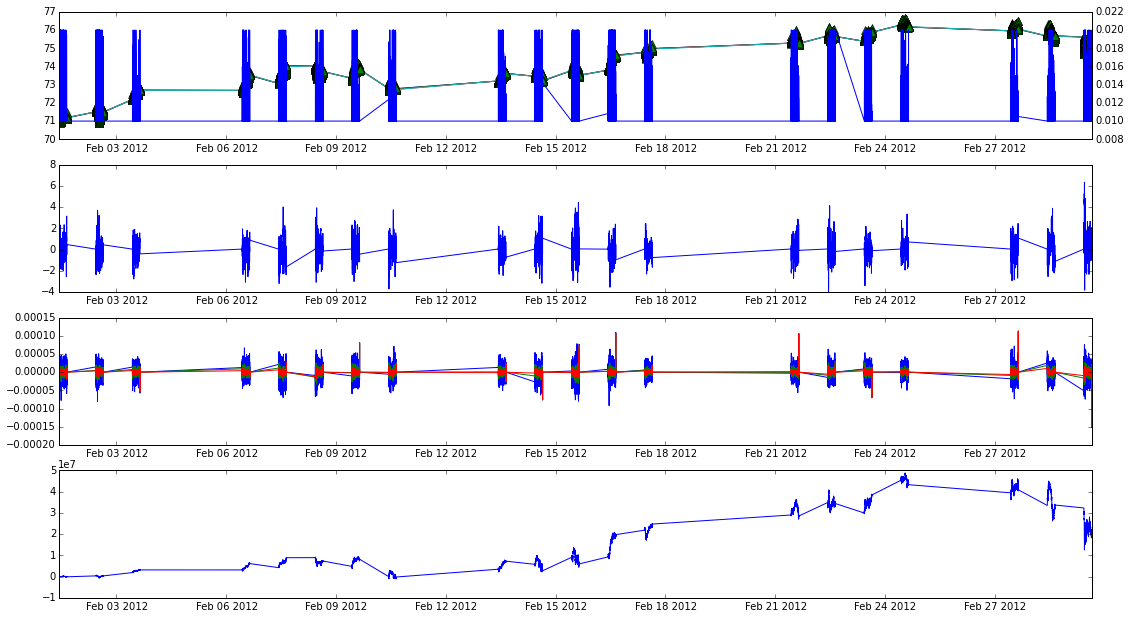

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4)
fig.set_size_inches(18.5, 10.5)
quotes = data

axes[0].plot(quotes['DATE_TIME'].values, quotes['price'].values)

for hl in hls:
    axes[0].plot(quotes['DATE_TIME'].values, quotes['EMA_{}'.format(hl)].values)

long_orders = filter(lambda x: x[2] > 0, order_history)
short_orders = filter(lambda x: x[2] < 0, order_history)
long_order_times = map(lambda x: x[0], long_orders)
short_order_times = map(lambda x: x[0], short_orders)
long_order_prices = map(lambda x: x[3], long_orders)
short_order_prices = map(lambda x: x[3], short_orders)

axes[0].plot(long_order_times, long_order_prices, '^', ms=8, color='g')
axes[0].plot(short_order_times, short_order_prices, 'v', ms=8, color='r')

ax2 = axes[0].twinx()
ax2.plot(quotes['DATE_TIME'].values, (quotes['ASK_PRICE']-quotes['BID_PRICE']).values)

axes[1].plot(quotes['DATE_TIME'].values, quotes['momentum'].values, label='momentum')

axes[2].plot(quotes['DATE_TIME'].values, quotes['log_returns_10+'].values, label='lr_10+')
axes[2].plot(quotes['DATE_TIME'].values, quotes['log_returns_40+'].values, label='lr_40+')
axes[2].plot(quotes['DATE_TIME'].values, quotes['log_returns_100+'].values, label='lr_100+')
plt.legend()

print len(pnl_history)
print len(quotes['DATE_TIME'])

axes[3].plot(quotes['DATE_TIME'].values, pnl_history, label='pnl')

plt.show()

